Import and download libraries

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional,Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import Regularizer
import tensorflow.keras.utils as ku 
import random

important functions

In [2]:
#make rows as dict
def gen_rows(df):
    for row in df.itertuples(index=False):
        yield row._asdict()

In [3]:
#randomizing data
def rndm(test_list1,test_list2):
  temp = list(zip(test_list1, test_list2))
  random.shuffle(temp)
  res1, res2 = zip(*temp)
  res1, res2 = list(res1), list(res2)
  return res1,res2

constant

In [4]:
stopword = [ "a", "about", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up",  "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with" ] 

In [5]:
embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size=2304 
test_portion=.3

import data

In [7]:
df=pd.read_csv('/content/tiga_tweet.csv')

In [8]:
#import from drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
tweets=df.tweet1+" "+df.tweet2+" "+df.tweet3

In [10]:
data_baru=pd.DataFrame(data={'TweetText':tweets,'target':df.target.to_list()})
data_baru.head()

,TweetText,target
0,the lack understanding small significant part ...,0
1,told parents depression hard get gen x people ...,0
2,depression something speak even going also dou...,0
3,made tortilla filled pb j my depression cured ...,0
4,i gon na need depression meds soon rainouts sp...,0


In [11]:

data_baru.TweetText

0       the lack understanding small significant part ...
1       told parents depression hard get gen x people ...
2       depression something speak even going also dou...
3       made tortilla filled pb j my depression cured ...
4       i gon na need depression meds soon rainouts sp...
                              ...                        
6289    dog say hi haha cant wait see up looks cut seb...
6290    did u forget i even alive did u forget everyth...
6291    pity dead pity living live without lov vettel ...
6292    hellen keller girl talk hips heading north hil...
6293    do makes happy makes smil this makes sad i non...
Name: TweetText, Length: 6294, dtype: object

In [12]:
#corpus
sentences = []
labels = []
fields = []
D1 = gen_rows(data_baru)
for i in range(len(data_baru)):
  d=next(D1)
  labels.append(d['target'])
  sentence = str(d['TweetText'])
  for word in stopword:
    token = " " + word + " "
    sentence = sentence.replace(token, " ")
    sentence = sentence.replace("  ", " ")
  sentences.append(sentence)
    
print(len(sentences))
print(sentences[0])

6294
the lack understanding small significant part causes anxiety depression feel incredibly lonely soooo easy compare easy invalid try hard even know thats lie dont know whats wrong anymore pissed away many good things life feel one persons fault ive dragging ball chain behind years nowi cant find motivation change situation ive put homeless lived bed truck kicked countless houses becausei ama terrible employee cant keep job quit tractor trailer driving job didnt want away family thati amhome cant muster strength look face anymorei always late rent cant control money nowi amsquatting run house holes roof walls ceiling plumbing electricity drop cord neighbors house cats years going town town job job house house feel likei amat point ive become burden everyone around cant ask help seems likei amalways leeching everyone sleep absolutely wake work dont even want awake anymore amwriting thought one would notice weeks maybe months despite everyone knows one cares visit call acknowledge exis

In [13]:
sentences,labels=rndm(sentences,labels)

In [14]:
tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(sentences) 

word_index = tokenizer.word_index
vocab_size=len(word_index)    

sequences = tokenizer.texts_to_sequences(sentences)  
padded = pad_sequences(sequences, maxlen=max_length, padding = padding_type, truncating=trunc_type)

split = int(test_portion * training_size)

test_sequences = padded[0:split] 
training_sequences = padded[split:training_size]
test_labels = labels[0:split]
training_labels = labels[split:training_size] 

In [15]:
embeddings_index = {};
with open('/content/drive/MyDrive/M_care/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [16]:
sentences[1]

'see i learned lot rpdri pan seeing strong individuals inspire mei anxiety depression watching katya miss fame made realize normal feel awfuli bulimic need help i exception recoveri running ideas feel like entire life distractions procrastinating one day run ways put suicidei amsick saying wait one day dont want try anymorei exhausted cant remember time depressed always something wrong wish rely someone else moments much burden carry ruin everything touch future cant keep got asked questions suicidal tendancies new clinic made uncomfortable going huge changes minute including moving parents house signed new mental health counsellor got urgant call back response severity desire kill ive pretfy good recently think move life start picking saying loud thoughts killing reminded uncommon intense thoughts find days unbearable best love full self hatr'

Model

In [36]:
model = tf.keras.Sequential([
    Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=True),
    Bidirectional(LSTM(150, return_sequences=True,name='Bi_LSTM')),
    Dropout(0.2),
    LSTM(50,name='Lstm_final'),
    Dropout(0.2),
    Dense(20, activation='relu'),
    Dense(2, activation='softmax')
])

In [37]:
model.compile(loss='binary_crossentropy', optimizer='SGD', metrics='accuracy') 

num_epochs = 40
history = model.fit(training_sequences, tf.one_hot(training_labels, 2), epochs=num_epochs, validation_data=(test_sequences, tf.one_hot(test_labels,2)), verbose=2)


Epoch 1/40
51/51 - 10s - loss: 0.6947 - accuracy: 0.4941 - val_loss: 0.6840 - val_accuracy: 0.5687 - 10s/epoch - 194ms/step
Epoch 2/40
51/51 - 3s - loss: 0.6843 - accuracy: 0.5859 - val_loss: 0.6711 - val_accuracy: 0.6585 - 3s/epoch - 65ms/step
Epoch 3/40
51/51 - 3s - loss: 0.6718 - accuracy: 0.6522 - val_loss: 0.6555 - val_accuracy: 0.7525 - 3s/epoch - 65ms/step
Epoch 4/40
51/51 - 3s - loss: 0.6542 - accuracy: 0.7551 - val_loss: 0.6392 - val_accuracy: 0.8321 - 3s/epoch - 65ms/step
Epoch 5/40
51/51 - 3s - loss: 0.6350 - accuracy: 0.7936 - val_loss: 0.6103 - val_accuracy: 0.8220 - 3s/epoch - 65ms/step
Epoch 6/40
51/51 - 3s - loss: 0.6069 - accuracy: 0.8184 - val_loss: 0.5757 - val_accuracy: 0.8452 - 3s/epoch - 66ms/step
Epoch 7/40
51/51 - 3s - loss: 0.5687 - accuracy: 0.8388 - val_loss: 0.5361 - val_accuracy: 0.8538 - 3s/epoch - 65ms/step
Epoch 8/40
51/51 - 3s - loss: 0.5207 - accuracy: 0.8568 - val_loss: 0.4753 - val_accuracy: 0.8669 - 3s/epoch - 65ms/step
Epoch 9/40
51/51 - 3s - loss:

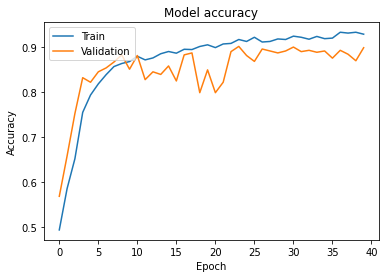

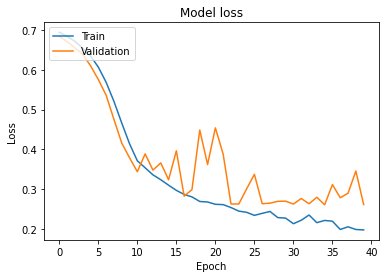

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Save Model to Json
model_json = model.to_json()
with open('model.json','w') as json_file:
    json_file.write(model_json)
model.save_weights('model.h5')

In [ ]:
with open('token.json','w') as json_file:
  json_file.write(tokenizer.to_json())

In [ ]:
from google.colab import files
files.download('token.json')
files.download('model.json')
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>